<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Tackle Imbalanced Data Challenge**


In this lab, you will identify the imbalanced data problems in four binary classification scenarios, all with skewed class distributions:


| Task Name                     | Class Ratio (Negative vs. Positive) |
| ----------------------------- | :---------------------------------: |
| *Credit Card Fraud Detection* |              ~1000 : 1              |
| *Predicting Customer Churn*   |                ~5 : 1               |
| *Tumor Type Estimation*       |                ~2 : 1               |
| *Predicting Job Change*       |               ~10 : 1               |


Next, you will try to tackle the imbalanced data challenges in the above tasks using class weighting and resampling methods:

*   Effective class weighting strategies will assign minority class with more weights, so that it may have a larger impact on the model training process
*   Resampling methods will generate synthetic datasets from the original datasets


## Objectives


After completing this lab you will be able to:


*   Identify typical patterns of imbalanced data challenges
*   Apply `Class Re-weighting` method to adjust the impacts of different classes in model training processes
*   Apply `Oversampling` and `Undersampling` to generate synthetic datasets and rebalance classes
*   Evaluate your consolidated classifiers using robust metrics such as `F-score` and `AUC`


***


First, let us import the required packages for this lab:


In [1]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.3 numpy==1.21.2 ipywidgets==7.4.2 scipy==7.4.2 tqdm==4.62.3 matplotlib==3.5.0 seaborn==0.9.0

# install imbalanced-learn package
!pip install imbalanced-learn==0.8.0

# Note: If your environment doesn't support "!mamba install", use "!pip install"


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
## Import packages here
import pandas as pd
import numpy as np 
import imblearn
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from collections import Counter

First, we want to provide some sample grid search methods if you are interested in tuning your model


In [3]:
rs = 123
# Grid search hyperparameters for a logistic regression model
def grid_search_lr(X_train, y_train):
    params_grid = {
    'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}]
    }
    lr_model = LogisticRegression(random_state=rs, max_iter=1000)
    grid_search = GridSearchCV(estimator = lr_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

# Grid search hyperparameters for a random forest model
def grid_search_rf(X_train, y_train):
    params_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [25, 50, 100],
    'min_samples_split': [2, 5],
    'class_weight': [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}]
    }
    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

and a method to split training and testing dataset


In [4]:
def split_data(df):
    X = df.loc[ : , df.columns != 'Class']
    y = df['Class'].astype('int')
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

## Scenario: Credit Card Fraud Detection


Let's start with a credit card fraud detection scenario.
The dataset contains transactions made by credit cards. As you can imagine, the majority of transactions are normal and only a very few real fraud transactions are in the dataset. Our goal is to train a classification model to recognize those fraudulent credit card transactions.


First, we load the dataset as a dataframe:


In [5]:
credit_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_credit.csv", index_col=False)

In [6]:
credit_df.head()

,V14,V17,V4,V10,V28,Class
0,0.423619,-0.210863,0.933459,0.027866,0.019308,0
1,0.986727,0.174009,-2.019905,-1.620065,-0.307753,0
2,-0.023094,-0.541985,-0.902618,-0.192212,-0.048965,0
3,-0.152111,-0.615094,1.276126,-0.026822,0.044480,0
4,-0.535807,-0.248563,4.517539,1.871441,0.120955,0


Due to confidentiality issues, the original features and other background information about each transaction is hidden, and this dataset now contains only numerical features which are the result of a PCA transformation.


Next, let's see  how imbalanced this dataset is:


In [7]:
credit_df['Class'].value_counts()

0    200000
1       200
Name: Class, dtype: int64

<AxesSubplot:>

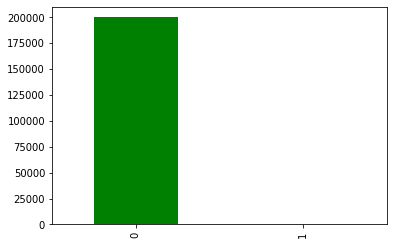

In [8]:
# Visualize the count for each class
credit_df['Class'].value_counts().plot.bar(color=['green', 'red'])

As you can see, we only have about 0.001% fraud transactions in the dataset and you can not even see it on the previous bar chart! This is an extremely imbalanced dataset


Next, we will quickly build a standard logistic regression model to see how it performs on such an imbalanced dataset.


In [9]:
# Split the training and testing dataset
X_train, X_test, y_train, y_test = split_data(credit_df)

In [10]:
# Build a simple logistic regression model
model = LogisticRegression(random_state=rs, 
                              max_iter = 1000)

# Train the model
model.fit(X_train, y_train)
preds = model.predict(X_test)

And check its prediction accuracy


In [11]:
accuracy_score(y_test, preds)

0.9992757242757243

OK, it achieves 99% prediction accuracy on the test dataset, looks like a great model! Before concluding we have found a simple and great model to detect credit card frauds, let's try other metrics first.


### More Robust Evaluation Metrics


Here are some effective robust binary classification evaluation metrics such as Precision, Recall, and Fscore, which can be defined as follows:


*   `Precision`: the percentage of accurately predicted positive instances

*   `Recall`: the percentage of successfully recognized positive instances

*   `Fscore`: can also be called F-beta score, which is a weighted average of precision and recall to evaluate the model. The weights between recall and precision are controlled by the `beta`  parameter, the default value is 1 so the most common F-beta is F1 score


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/images/evaluation_metrics.png" width="720" alt="evaluation metrics"  />
</center>


Además, la gráfica de la tasa de verdaderos positivos y la proporción de falsos positivos bajo diferentes umbrales, conocida como característica operativa del receptor `ROC` y su área asociada bajo la curva `AUC`, también son métricas confiables.

First let's calculate Precision, Recall, and Fscore.


In [12]:
# Calculate the precision, recall, f5 given the y_test and predictions
# Note that we use beta=5 which means we think the cost of positive class is 5 times of negative class
# You could try other beta values yourself
accuracy = accuracy_score(y_test, preds)
precision, recall, fbeta, support = precision_recall_fscore_support(y_test, preds, beta=5, pos_label=1, average='binary')
auc = roc_auc_score(y_test, preds)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {fbeta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 1.00
Precision is: 0.72
Recall is: 0.45
Fscore is: 0.46
AUC is: 0.72


Para muchas tareas de aprendizaje automático en conjuntos de datos desequilibrados, como esta detección de fraude con tarjetas de crédito, normalmente nos preocupamos más por la sensibilidad que por la precisión. Como referencia, queremos que el modelo sea capaz de encontrar todos los fraudes y permitiríamos que el modelo cometiera errores de falsos positivos porque el costo de los falsos positivos generalmente no es muy alto (tal vez solo cueste un correo electrónico de notificación falso o una llamada telefónica a confirmar con los clientes). Por otro lado, no reconocer ejemplos positivos (como un fraude o una enfermedad mortal) puede poner en peligro la vida.

Como tal, nuestra prioridad es mejorar la sensibilidad del modelo, entonces también querremos mantener la precisión lo más alta posible.


### Synthetic Minority Oversampling Technique (SMOTE)


SMOTE primero crea muchos pares o pequeños grupos con dos o más instancias similares, la distancia usada es la distancia euclidiana.
Luego, dentro del límite de cada par o grupo, SMOTE permuta uniformemente el valor de las características, una característica a la vez, para llenar una colección de instancias sintetizadas similares dentro de cada par o grupo.

Como resultado, SMOTE crea un conjunto de datos sintéticos de clase equilibrada sin agregar instancias duplicadas con etiquetas minoritarias.

El paquete `imblearn` nos proporciona muchas muestras efectivas que incluyen `SMOTE`, `RandomOverSampler` y `RandomUnderSampler`. 


In [13]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [14]:
# Create a SMOTE sampler
smote_sampler = SMOTE(random_state = rs)

In [15]:
# Resample training data using SMOTE
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

Después del remuestreo SMOTE, podemos ver que tanto la clase positiva como la negativa tienen las mismas instancias

<AxesSubplot:>

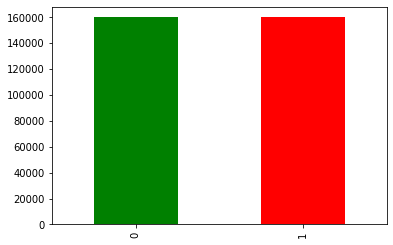

In [16]:
# Visualize classes
y_smo.value_counts().plot.bar(color=['green', 'red'])

Volvamos a entrenar el modelo de regresión logística con datos de entrenamiento remuestreados usando SMOTE

In [17]:
# Re-train the model with resampled data
model.fit(X_smo, y_smo)
preds = model.predict(X_test)

y reevaluemos el modelo para ver si hay alguna mejora con respecto a Precisión, Recuperación y F1


In [18]:
# Calculate the precision, recall, f5 given the y_test and predictions
# Note that we use beta=5 which means we think the cost of positive class is 5 times of negative class
# You could try other beta values yourself
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, preds, beta=5, pos_label=1, average='binary')
auc = roc_auc_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 0.97
Precision is: 0.03
Recall is: 0.88
Fscore is: 0.42
AUC is: 0.92


Primero, podemos ver que AUC ha mejorado de 0.72 a 0.91, esta es una buena señal ya que SMOTE mejora la capacidad de clasificación del modelo.


A continuación, echemos un vistazo a la sensibilidad. Esta es ahora de 0,88, casi dos veces mayor que el valor original de 0,45.


Sin embargo, la precisión de nuestro modelo es solo 0.03. Una posible razón es que nuestro conjunto de datos estaba extremadamente sesgado, y el sobremuestreo de la clase minoritaria quebranta significativamente la distribución de datos original, de modo que el modelo entrenado en el conjunto de datos SMOTE genera grandes falsos positivos en el conjunto de datos de prueba del conjunto de datos original.


Como tal, para un conjunto de datos extremadamente sesgado, generalmente no usamos el sobremuestreo, ya que cambia significativamente la distribución de datos original.

A continuación, intentemos usar class reweighting para ver si puede lograr mejores resultados que SMOTE en términos de precisión, recuperación y puntuación F.


### Class reweighting


Para los modelos de clasificación binaria, su función de pérdida normalmente se calcula a través de la suma de la pérdida con respecto a la clase 0 y la pérdida con respecto a la clase 1. De forma predeterminada, sus pesos de clase son todos 1, lo que significa que tratamos a cada clase con la misma importancia.

Sin embargo, dado que la distribución de clases está sesgada en conjuntos de datos desequilibrados y el proceso de optimización de la función de pérdida estará dominado por la clase mayoritaria, queremos ayudar a la clase minoritaria aumentando su peso de clase en la función de pérdida.

Los pesos de las clases se pueden calculan generalmente a través de las siguientes tres estrategias:

* Basado en su cantidad de observaciones en el conjunto de datos. Por ejemplo, si las instancias positivas solo toman el 10% del conjunto de datos, le asignamos un peso de 0,9 y el peso de la clase mayoritaria de 0,1.
* Heurística o dominio del conocimiento. La clasificación errónea normalmente tiene diferentes costos por clase, por ejemplo, el costo de no diagnosticar una enfermedad es mucho más alto que un diagnóstico falso positivo. Si ya conocemos dichos costos de clasificación errónea de antemano, podemos usarlos para asignar pesos de clase
* Sintonización de hiperparámetros. Los métodos estándar de ajuste de hiperparámetros se pueden utilizar para encontrar pesos de clase optimizados. Por ejemplo, la búsqueda en cuadrícula de 0,1 a 0,9 para el peso de clase positivo para averiguar qué combinación de hiperparámetros genera el mejor modelo.


El paquete de Python `sklearn` provee una manera conveniente de ajustar el peso de las clases durante el entrenamiento de los modelos a través del argumento class weight. Muchos clasificadores en `sklearn` como `LogisticRegression` y `RandomForestClassifier` soportan por defecto el class reweighting.


Ejemplo en `LogisticRegression`:


In [19]:
class_weight = {}

# Assign weight of class 0 to be 0.1
class_weight[0] = 0.1

# Assign weight of class 1 to be 0.9
class_weight[1] = 0.9

Tenga en cuenta que `0.1 vs. 0.9` es una combinación de peso preajustada, puede verificar el método `grid_search_lr()` proporcionado al comienzo de esta práctica de laboratorio y usarlo para ajustar los pesos de clase optimizados usted mismo.

In [20]:
# Define a logistic regression with weight
model = LogisticRegression(random_state=rs, 
                              max_iter = 1000,
                              class_weight=class_weight)

Durante el proceso de entrenamiento, la instancia positiva tendrá una influencia mucho mayor en la reducción de la pérdida total y las actualizaciones de peso. El clasificador entrenado se mejorará para reconocer instancias positivas (aumentar la sensibilidad).


In [21]:
# Train the model
model.fit(X_train, y_train)
# Make predictions on the test dataset
preds = model.predict(X_test)

Next, let's see if our metrics are getting better.


In [22]:
# Calculate the precision, recall, f5 given the y_test and predictions
# Note that we use beta=5 which means we think the cost of positive class is 5 times of negative class
# You could try other beta values yourself
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, preds, beta=5, pos_label=1, average='binary')
auc = roc_auc_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 1.00
Precision is: 0.65
Recall is: 0.82
Fscore is: 0.82
AUC is: 0.91


Como puede ver, tenemos valores de `Precisión` y `Sensibilidad` muy equilibrados. Indica que, para un conjunto de datos extremadamente desequilibrado como la detección de fraudes con tarjetas de crédito, a menudo la reponderación de clases es una mejor estrategia que el sobremuestreo. Dado que el submuestreo reducirá significativamente el conjunto de datos de entrenamiento, normalmente no usamos el submuestreo para un conjunto de datos extremadamente desequilibrado.


Para resumir los resultados de la tarea de detección de fraude con tarjetas de crédito:

* Todos los modelos tienen valores de precisión y AUC muy altos, pero esto no siempre significa que tengan un buen rendimiento de predicción, especialmente para clasificar los casos de fraude.
* La clasificación en un conjunto de datos extremadamente desequilibrado suele ser una tarea difícil, especialmente si queremos tener valores altos de sensibilidad y precisión.
* `SMOTE` puede lograr una alta sensibilidad pero una precisión extremadamente baja debido a la distribución de datos originales
* La reponderación de clase puede lograr un valor de sensibilidad y precisión más equilibrado

## Algunos métodos de entrenamiento y evaluación de modelos de utilidad


Antes de continuar con más escenarios de clasificación desequilibrados, definamos algunos métodos de utilidad para simplificar este laboratorio y aumentar la legibilidad del cuaderno. Un método para definir y entrenar una regresión logística:

In [23]:
rs = 123
# Build a logistic regression model
def build_lr(X_train, y_train, X_test, threshold=0.5, best_params=None):
    
    model = LogisticRegression(random_state=rs, 
                              max_iter = 1000)
    # If best parameters are provided
    if best_params:
        model = LogisticRegression(penalty = 'l2',
                              random_state=rs, 
                              max_iter = 1000,
                              class_weight=best_params['class_weight'])
    # Train the model
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

Un método para definir y entrenar un bosque aleatorio:

In [24]:
def build_rf(X_train, y_train, X_test, threshold=0.5, best_params=None):
    
    model = RandomForestClassifier(random_state = rs)
    # If best parameters are provided
    if best_params:
        model = RandomForestClassifier(random_state = rs,
                                   # If bootstrap sampling is used
                                   bootstrap = best_params['bootstrap'],
                                   # Max depth of each tree
                                   max_depth = best_params['max_depth'],
                                   # Class weight parameters
                                   class_weight=best_params['class_weight'],
                                   # Number of trees
                                   n_estimators=best_params['n_estimators'],
                                   # Minimal samples to split
                                   min_samples_split=best_params['min_samples_split'])
    # Train the model   
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

Un método para evaluar las predicciones de un clasificador


In [25]:
rs = 123
def evaluate(yt, yp, eval_type="Original"):
    results_pos = {}
    results_pos['type'] = eval_type
    # Accuracy
    results_pos['accuracy'] = accuracy_score(yt, yp)
    # Precision, recall, Fscore
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, beta=5, pos_label=1, average='binary')
    results_pos['recall'] = recall
    # AUC
    results_pos['auc'] = roc_auc_score(yt, yp)
    # Precision
    results_pos['precision'] = precision
    # Fscore
    results_pos['fscore'] = f_beta
    return results_pos

Un método para volver a muestrear el conjunto de datos original


In [26]:
def resample(X_train, y_train):
    # SMOTE sampler (Oversampling)
    smote_sampler = SMOTE(random_state = 123)
    # Undersampling
    under_sampler = RandomUnderSampler(random_state=123)
    # Resampled datasets
    X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
    X_under, y_under = under_sampler.fit_resample(X_train, y_train)
    return X_smo, y_smo, X_under, y_under

Y un método para visualizar métricas


In [27]:
def visualize_eval_metrics(results):
    df = pd.DataFrame(data=results)
    #table = pd.pivot_table(df, values='type', index=['accuracy', 'precision', 'recall', 'f1', 'auc'],
    #                columns=['type'])
    #df = df.set_index('type').transpose()
    print(df)
    x = np.arange(5)
    original = df.iloc[0, 1:].values
    class_weight = df.iloc[1, 1:].values
    smote = df.iloc[2, 1:].values
    under = df.iloc[3, 1:].values
    width = 0.2
    figure(figsize=(12, 10), dpi=80)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, class_weight, width, color='#d35400')
    plt.bar(x+0.2, smote, width, color='#2980b9')
    plt.bar(x+0.4, under, width, color='#3498db')
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Score")
    plt.legend(["Original", "Class Weight", "SMOTE", "Undersampling"])
    plt.show()

## Escenario: predicción de abandono de clientes


En el segundo escenario, pronosticaremos abandonos de clientes (abandono del negocio) de una empresa de telecomunicaciones.


In [28]:
churn_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_churn.csv", index_col=False)

In [29]:
churn_df.head()

,tenure,MonthlyCharges,TotalCharges,Partner_0,Partner_1,Dependents_0,Dependents_1,PhoneService_0,PhoneService_1,MultipleLines_0,...,Contract_0,Contract_1,Contract_2,PaperlessBilling_0,PaperlessBilling_1,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,Class
0,27,70.55,1943.90,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
1,69,93.30,6398.05,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,55,59.20,3175.85,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0
3,49,59.60,2970.30,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,72,109.55,7887.25,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0


Este conjunto de datos se procesa y contiene funciones sobre los tipos de servicio de telecomunicaciones, la tenencia, los cargos y los pagos de un cliente. Con base en tales características, nos gustaría predecir si un cliente dejará el negocio o no (churn).


In [30]:
X_train, X_test, y_train, y_test = split_data(churn_df)

<AxesSubplot:>

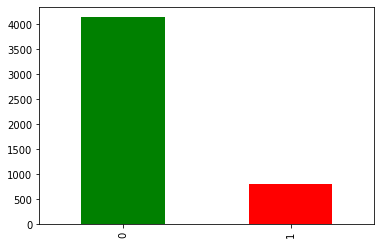

In [31]:
y_train.value_counts().plot.bar(color=['green', 'red'])

Como podemos ver en el gráfico de barras anterior, los clientes que no abandonan son casi 4 veces más que los clientes que abandonan, lo que también lo convierte en un conjunto de datos desequilibrado. Dado que este conjunto de datos tiene 42 características, sería mejor usar un modelo de clasificación más complejo y elegimos usar `RandomForestClassifier` del paquete `sklearn`.

In [32]:
# Tuned random forest parameters
best_params_no_weight = {'bootstrap': True,
                         'class_weight': None, 
                         'max_depth': 10, 
                         'min_samples_split': 5, 
                         'n_estimators': 50}

In [33]:
results = []

### Train a regular random forest classifier


Luego, entrenaremos un clasificador de bosque aleatorio regular sin ningún complemento (pesos de clase o remuestreo).


In [60]:
preds, model = build_rf(X_train, y_train, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds, "Original")
display(pd.Series(result))
results.append(result)

type         Original
accuracy     0.984962
recall            1.0
auc          0.988764
precision    0.956522
fscore       0.998255
dtype: object

As you may expect, we have a very high prediction `accuracy` but even using a random forest classifier, our `recall` is very low with only 0.28.
Next, let's try the class reweighting method to see if we can improve the performance.


### Agregando class re-weighting


Agregaremos pesos de clase al clasificador de bosque aleatorio con un peso preajustado de 0,8 para la clase de abandono y un peso de 0,2 para la clase de no abandono.


In [35]:
class_weight = {}
# 0.2 to Non-churn class
class_weight[0] = 0.2
# 0.8 to Churn class
class_weight[1] = 0.8

In [36]:
# Pre-tuned hyper parameters
best_params_weight = {'bootstrap': True,
                         'class_weight': class_weight, 
                         'max_depth': 10, 
                         'min_samples_split': 5, 
                         'n_estimators': 50}

In [63]:
# class weight
preds_cw, weight_model = build_rf(X_train, y_train, X_test, best_params=best_params_weight)

In [65]:
result = evaluate(y_test, preds_cw, "Class Weight")
display(pd.Series(result))
results.append(result)

type         Class Weight
accuracy         0.992481
recall                1.0
auc              0.994382
precision        0.977778
fscore           0.999127
dtype: object

Como podemos ver en los resultados de la evaluación anterior, `Recall` y `Fscore` mejoran significativamente al agregar pesos de clase. Tales mejoras indican que la reponderación de clases es efectiva para el conjunto de datos de abandono de clientes desequilibrado.


### Resampling: SMOTE y Undersampling


Luego, queremos usar el remuestreo para ver si también puede mejorar el rendimiento del modelo.


Primero, creamos conjuntos de datos de entrenamiento remuestreados:

In [39]:
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

Luego, podemos volver a entrenar un clasificador de bosque aleatorio utilizando la entrada remuestreada `X_smo` de SMOTE y la salida `y_smo` y evaluar su rendimiento,


In [66]:
preds_smo, smo_model = build_rf(X_smo, y_smo, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds_smo, "SMOTE")
display(pd.Series(result))
results.append(result)

type            SMOTE
accuracy     0.992481
recall            1.0
auc          0.994382
precision    0.977778
fscore       0.999127
dtype: object

y podemos volver a entrenar un clasificador de bosque aleatorio utilizando la entrada submuestreada `X_under` y la salida `y_under` y evaluar su rendimiento.


In [67]:
preds_under, under_model = build_rf(X_under, y_under, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds_under, "Undersampling")
display(pd.Series(result))
results.append(result)

type         Undersampling
accuracy          0.984962
recall                 1.0
auc               0.988764
precision         0.956522
fscore            0.998255
dtype: object

### Comparando el rendimiento de los diferentes modelos de random forest


Por ahora, hemos construido cuatro modelos de bosque aleatorio diferentes: el modelo entrenado con el conjunto de datos original, el modelo con pesos de clase, el modelo entrenado con el conjunto de datos SMOTE y el modelo entrenado con submuestreo.

Para analizar y comparar mejor su rendimiento, podemos visualizar las métricas mediante un gráfico de barras agrupadas.


            type  accuracy  recall       auc  precision    fscore
0       Original  0.862348   0.280  0.627440   0.682927  0.286501
1   Class Weight  0.813765   0.620  0.735604   0.446043  0.610837
2          SMOTE  0.839676   0.525  0.712742   0.504808  0.524194
3  Undersampling  0.733603   0.790  0.756353   0.355056  0.754454


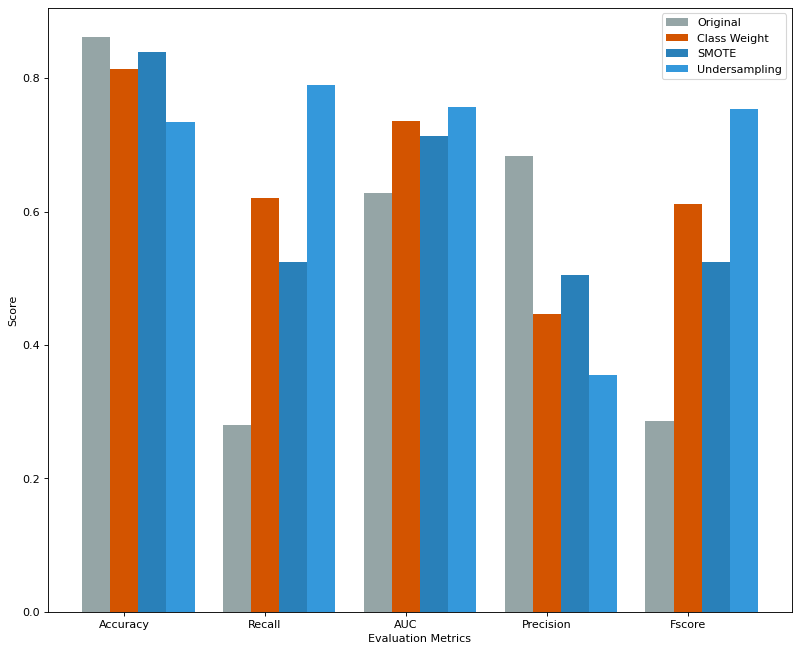

In [42]:
visualize_eval_metrics(results)

Primero veamos qué significa cada color. Las barras grises representan el modelo original, las barras naranjas representan el modelo con peso de clase, las barras azul oscuro representan el modelo entrenado con SMOTE y las barras azul claro representan el modelo entrenado con submuestreo.

Como podemos inferir las siguientes ideas de los gráficos de barras:

* Todos los modelos tienen alta precisión
* La sensibilidad se mejora con pesos de clase y métodos de remuestreo, y el submuestreo produce la recuperación más alta
* El AUC también se mejora con pesos de clase y métodos de remuestreo, y el submuestreo produce nuevamente el AUC más alto
* Las precisiones disminuyen con los pesos de clase y los métodos de remuestreo, ya que todos ellos introdujeron muchos falsos positivos (que se esperan, ya que estamos tratando de aumentar el impacto de la clase positiva)
* Fscore se mejora con pesos de clase y método de remuestreo, y el submuestreo tiene el Fscore más alto


Al analizar el gráfico de barras anterior, podemos ver que el submuestreo parece ser el mejor método para el desafío de clases imbalanceadas en el conjunto de datos de abandono de clientes. Aunque todos los pesos de clase, SMOTE y submuestreo redujeron la precisión (aumentaron los falsos positivos), pero a veces no es una mala idea asumir que algunos de sus clientes están a punto de irse (incluso si no lo están) como motivación para mejorar sus servicios.

## Escenario: estimación del tipo de tumor


Por último, veamos un conjunto de datos desequilibrado interesante que tiene una precisión, una recuperación y una puntuación F muy altas inicialmente sin usar la reponderación de clase ni el remuestreo.


Este conjunto de datos contiene muestras de tumores y necesitamos estimar/predecir si una muestra de tumor es cancerosa o no.

Primero, como en otros escenarios, carguemos y dividamos el conjunto de datos


In [43]:
tumor_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_cancer.csv", index_col=False)
X_train, X_test, y_train, y_test = split_data(tumor_df)

<AxesSubplot:>

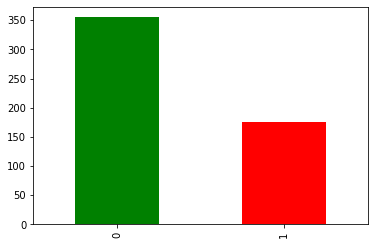

In [44]:
y_train.value_counts().plot.bar(color=['green', 'red'])

Como podemos ver, este conjunto de datos no está tan desequilibrado como los conjuntos de datos anteriores. Por lo tanto, es posible que no necesitemos usar la reponderación y el remuestreo de clase para tener un buen rendimiento de clasificación.

In [45]:
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

In [46]:
best_params_weight = {'bootstrap': True,
                         'class_weight': {0: 0.2, 1: 0.8}, 
                         'max_depth': 10, 
                         'min_samples_split': 5, 
                         'n_estimators': 50}

In [47]:
# no class-weights
results=[]
preds, model = build_rf(X_train, y_train, X_test)
results.append(evaluate(y_test, preds))
# class weight
preds, model = build_rf(X_train, y_train, X_test, best_params=best_params_weight)
results.append(evaluate(y_test, preds))
# Resampling
preds, model = build_rf(X_smo, y_smo, X_test)
results.append(evaluate(y_test, preds))
preds, model = build_rf(X_under, y_under, X_test)
results.append(evaluate(y_test, preds))

       type  accuracy  recall       auc  precision    fscore
0  Original  0.984962     1.0  0.988764   0.956522  0.998255
1  Original  0.992481     1.0  0.994382   0.977778  0.999127
2  Original  0.992481     1.0  0.994382   0.977778  0.999127
3  Original  0.984962     1.0  0.988764   0.956522  0.998255


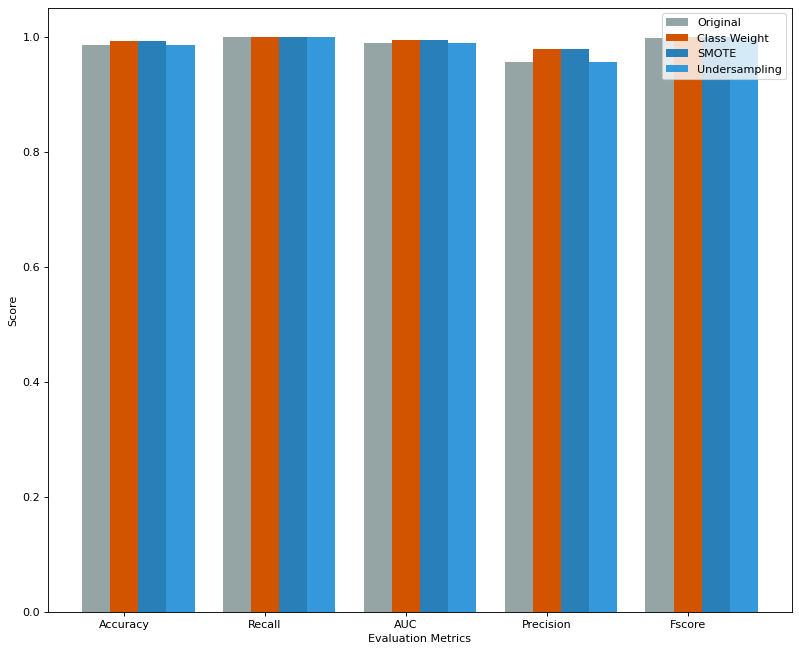

In [48]:
visualize_eval_metrics(results)

Como podemos ver, todas las barras grises (el modelo original) para Accuracy, Recall, AUC, Precision y F-score tienen valores muy altos y agregar reponderación de clase y remuestreo no ayuda a mejorar mucho el rendimiento. Es posible que los patrones tumorales en este conjunto de datos sean obvios y que el modelo de bosque aleatorio estándar los detecte fácilmente o que el conjunto de datos no esté muy desequilibrado y se pueda considerar como una tarea de clasificación binaria ordinaria.


## Ejercicio: Predicción del cambio de trabajo


Ahora es el momento de aplicar lo que ha aprendido en este laboratorio. Tenemos un conjunto de datos de recursos humanos desequilibrado y queremos usarlo para construir un modelo de clasificación para predecir si un empleado está buscando un nuevo trabajo o no.

In [49]:
# Load the dataset
hr_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_hr.csv", index_col=False)

### Check its class distribution


In [50]:
# type your code here

### Split the dataset


In [51]:
# type your code here

### Build a logistic regression model with the original dataset


In [52]:
# type your code here

### Add class weights to the model


In [53]:
# type your code here

### Improve the model with SMOTE resampled dataset


In [54]:
# type your code here

### Improve the model with Undersampling resampled dataset


In [55]:
# type your code here

<details><summary>Click here for a solution</summary>

```python
y_train.value_counts().plot.bar(color=['green', 'red'])
best_params = {'class_weight': {0: 0.1, 1: 0.9}}
results = []
# no class-weights
preds, model = build_lr(X_train, y_train, X_test)
result = evaluate(y_test, preds)
results.append(result)
# class weight
preds, weight_model = build_lr(X_train, y_train, X_test, best_params=best_params)
result = evaluate(y_test, preds, eval_type="Class Weight")
results.append(result)
# Resampling
preds, smote_model = build_lr(X_smo, y_smo, X_test)
result = evaluate(y_test, preds, eval_type="SMOTE")
results.append(result)
preds_under, under_model = build_lr(X_under, y_under, X_test)
result = evaluate(y_test, preds_under, eval_type="Undersampling")
#metrics.plot_roc_curve(smote_model, X_test, y_test) 
results.append(result)
visualize_eval_metrics(results)
```

</details>


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01)


### Other Contributors


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description          |           |     |            |         |
| ----------------- | ------- | ---------- | --------------------------- | --------- | --- | ---------- | ------- |
| 2021-9-23         | 1.0     | Yan        | Created the initial version | 2022-2-23 | 1.2 | Steve Hord | QA pass |


Copyright © 2021 IBM Corporation. All rights reserved.
